This notebook showcases basic ways how to do regression and uncertainty quantification with different methods and libraries:
* scipy.stats.linregress
* scipy.optimize.curve_fit
* sklearn.linear_model.LinearRegression
* manual bootstrap
* bootstrap using arch library
* Bayesian inference with PyMC library




In [1]:
# libraries we will use and demonstrate here
import matplotlib.pyplot as plt  # standard plotting library
import numpy as np  # standard numerical library
import pandas as pd  # tabular data manipulation
from tqdm import tqdm  # easy to use progress bar

In [2]:
plt.style.use('seaborn-v0_8-talk')  # Clean, presentation-friendly style

# Linear Regression with Normal noise

Here we will assume that we know the true data-generating process, which is given by a probabilistic forward model:

$$
\mathbf{y} = \mathbf{a}\cdot\mathbf{X} + \mathbf{b} + \boldsymbol{\epsilon},
$$
$$
\boldsymbol{\epsilon} \sim \mathcal{N}(0, \sigma^2),
$$

where $\mathbf{a}, \mathbf{b}, \sigma$ are unknown parameters and $\boldsymbol{\epsilon}$ is randomly distributed homoscedastic noise (i.e. the variance is the same for all observations). And $X$ and $y$ are **independent** observations (i.e. the covariance matrix is diagonal).

N.B.: The case when the observations are correlated will be discussed later during the course, during the discussion of Gaussian Process Tomography.

In [3]:
# this is the true data generating process as well as the model function
def linear_model(x: np.ndarray, a: np.ndarray, b: np.ndarray) -> np.ndarray:
    return a * x + b

In [4]:
### SET THE MODEL PARAMETERS ###
a_true = np.array([3.75])
b_true = np.array([9.51])

### SET THE OBSERVATION NOISE ###
noise_cov_true = np.array([[36.60]])

### SET THE PROBLEM HYPERPARAMETERS ###
n_x_samples = 30  # number of observed data points
n_posterior_samples = 1000  # number of samples drawn from the posterior distribution
xmin = 0
xmax = 10

In [5]:
# generate synthetic data using the parameters from the previous cell
np.random.seed(42)  # make the random numbers predictable!

x = np.sort(np.random.rand(n_x_samples) * (xmax - xmin) + xmin)
y_true = linear_model(
    x=x,
    a=a_true,
    b=b_true,
)
y_observed = y_true + np.random.multivariate_normal(mean=[0], cov=noise_cov_true, size=x.size).ravel()


Let's define a convenience functions to plot the data and their uncertainty.

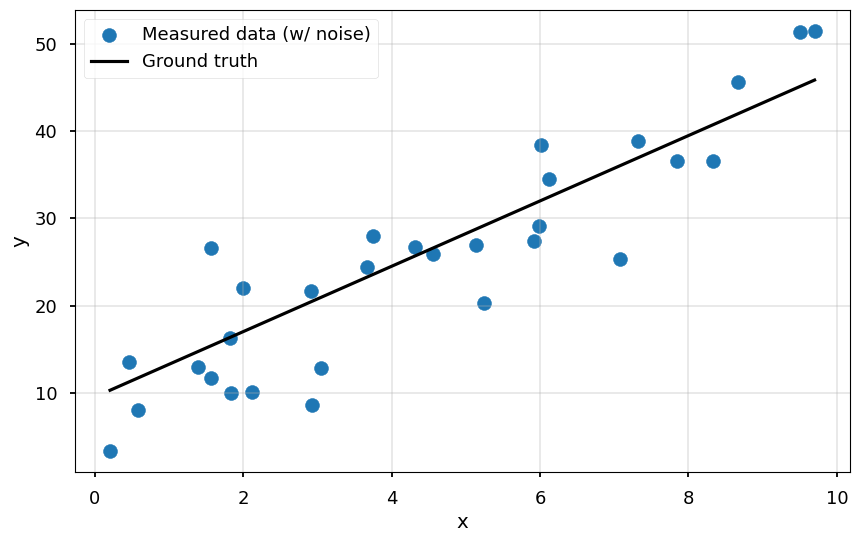

In [6]:
def plot_data(x: np.ndarray, y_observed: np.ndarray, y_true: np.ndarray | None = None, ax: plt.Axes | None = None, legend: bool = True, grid: bool = True) -> plt.Axes:
    """Helper function to plot the measured data and the ground truth.

    Parameters
    ----------
    x : np.ndarray
        The x-coordinates of the data points.
    y_observed : np.ndarray
        The y-coordinates of the measured data points.
    y_true : np.ndarray | None, optional
        The y-coordinates of the ground truth data points. If None, the ground truth is not plotted.
    ax : plt.Axes | None, optional
        The axes to plot the data on. If None, the current axes is used.

    Returns
    -------
    plt.Axes
        The axes on which the data was plotted.
    """
    ax = ax or plt.gca()
    ax.scatter(x, y_observed, label='Measured data (w/ noise)', s=100)
    if y_true is not None:
        plt.plot(x, y_true, '-k', label=f'Ground truth')
    plt.xlabel('x')
    plt.ylabel('y')
    if legend:
        plt.legend()
    if grid:
        plt.grid(True, alpha=0.3)

    return ax


def plot_posterior_model(
    x: np.ndarray,
    y_true_posterior: np.ndarray,
    ax: plt.Axes | None = None,
    alpha: float | None = None,
    legend: bool = True,
    posterior_label: str = 'Posterior predictive',
) -> plt.Axes:
    """Helper function to plot the posterior predictive of the true model.

    Parameters
    ----------
    x : np.ndarray
        The x-coordinates of the data points.
    y_true_posterior : np.ndarray
        The y-coordinates of the posterior predictive distribution.
    ax : plt.Axes | None, optional
        The axes to plot the data on. If None, the current axes is used.

    Returns
    -------
    plt.Axes
        The axes on which the data was plotted.
    """

    ax = ax or plt.gca()
    if y_true_posterior.ndim == 1:
        y_true_posterior = y_true_posterior.reshape(-1, 1)
    if x.ndim == 1:
        x = x.reshape(-1, 1)
    alpha = alpha or 1 / (y_true_posterior.shape[1] ** 0.75)  # The more posterior samples, the more transparent the line should be, but not too fast

    ax.plot(x, y_true_posterior, color='red', alpha=alpha)
    ax.plot([], [], color='red', label=posterior_label)
    if legend:
        plt.legend()

    return ax

def plot_parameter_uncertainty(
    fit_means: np.ndarray,
    fit_covs: np.ndarray,
    legend: bool = True,
) -> plt.Axes:
    """Helper function to visualize the uncertainty of the parameters using scatter plot and histograms.

    Parameters
    ----------
    fit_means : np.ndarray
        The mean values of the parameters.
    fit_covs : np.ndarray
        The covariance matrices of the parameters.
    legend : bool, optional
        Whether to show the legend.

    Returns
    -------
    plt.Axes
        The axes on which the data was plotted.
    """

    plt.subplot(2, 2, 1)
    plt.scatter(fit_means[:, 0], fit_means[:, 1], s=10, alpha=0.3)
    plt.plot(a_true, b_true, 'ok', label='Ground truth', markersize=10)
    plt.xlabel('a')
    plt.ylabel('b')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 2)
    plt.scatter(fit_means[:, 0], fit_covs[:, 0, 0], s=10, alpha=0.3)
    plt.xlabel('a')
    plt.ylabel('Var a')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 3)
    plt.hist(fit_means[:, 0], bins=20, alpha=0.5)
    plt.axvline(a_true[0], color='k', label='Ground truth')
    plt.xlabel('a')
    plt.ylabel('N')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.subplot(2, 2, 4)
    plt.hist(fit_means[:, 1], bins=20, alpha=0.5)
    plt.axvline(b_true[0], color='k', label='Ground truth')
    plt.xlabel('b')
    plt.ylabel('N')
    plt.grid(True, alpha=0.3)
    if legend:
        plt.legend()

    plt.tight_layout()


# test the plot functions and visualize the data
plt.figure(figsize=(10, 6))
plot_data(x, y_observed, y_true);

### Scipy

There are several specialized functions in scipy to do least-squares regression. Some are specialized for linear regression, some for non-linear regression. Here we will use the `scipy.stats.linregress` and `scipy.optimize.curve_fit` functions. The first is fast, but only for linear models. The second is flexible and can be used for any model function, but is slower. The functions estimate the parameters $\mathbf{\theta}$ as well as the covariance matrix of the parameters.



In [7]:
from scipy.stats import linregress  # linear least squares fitting
from scipy.optimize import curve_fit  # general least squares fitting

In [8]:
%%timeit
# fit the model on the data using linregress
linregress(x, y_observed)

82.2 μs ± 655 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [9]:
%%timeit
# fit the model on the data using curve_fit
curve_fit(f=linear_model, xdata=x, ydata=y_observed)

219 μs ± 2.39 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [10]:
# compare the results
fit_results_linregress = linregress(x, y_observed)
curve_fit_mean, curve_fit_cov = curve_fit(f=linear_model, xdata=x, ydata=y_observed)

# store the results in a dataframe (will be printed at the end of the notebook)
fit_results_df = pd.DataFrame(
    {
        'method': ['true parameters','curve_fit', 'linregress'],
        'a': [a_true[0], curve_fit_mean[0], fit_results_linregress.slope],
        'b': [b_true[0], curve_fit_mean[1], fit_results_linregress.intercept],
        'a_err': [np.nan, np.sqrt(curve_fit_cov[0, 0]), fit_results_linregress.stderr],
        'b_err': [np.nan, np.sqrt(curve_fit_cov[1, 1]), fit_results_linregress.intercept_stderr],
        'ab_cov': [np.nan, curve_fit_cov[0, 1], np.nan],
    }
).set_index('method')
fit_results_df


,a,b,a_err,b_err,ab_cov
method,,,,,
true parameters,3.750000,9.510000,NaN,NaN,NaN
curve_fit,4.121503,6.779359,0.366494,1.902464,-0.589114
linregress,4.121503,6.779359,0.366494,1.902464,NaN


The `curve_fit` is just ~3x slower than the linregress ==> often ok to use `curve_fit` as universal least squares fitter even if the model is linear. Moreover, `curve_fit` provides the full covariance matrix of the parameter uncertainties, while `linregress` just the diagonal terms.

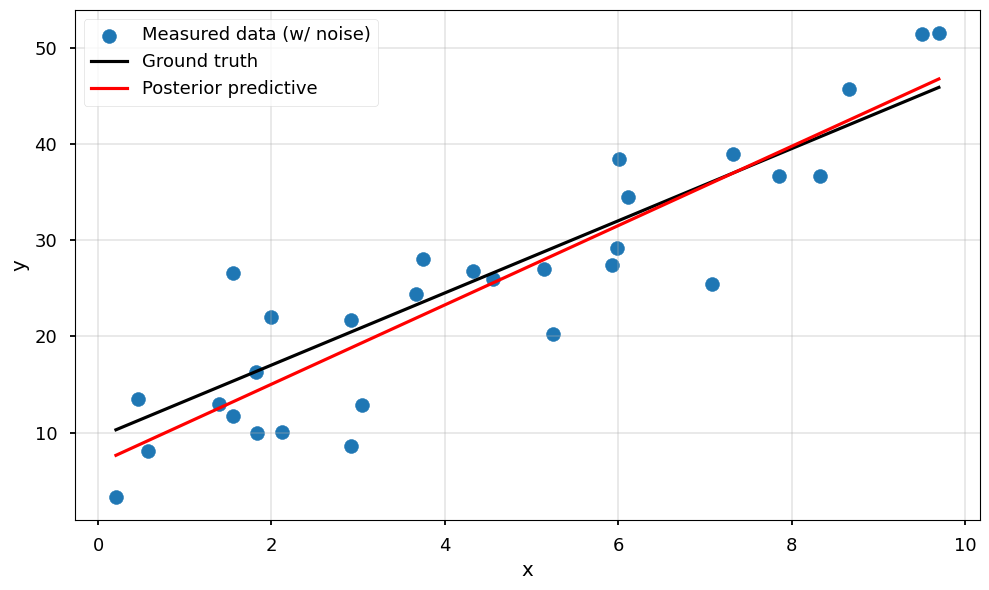

True parameters:
a = 3.75, b = 9.51, sigma = 6.05
Estimated parameters:
a = 4.12 ± 0.13, b = 6.78 ± 3.62, sigma = 5.38


In [11]:
curve_fit_mean, curve_fit_cov = curve_fit(
    f=linear_model,
    xdata=x,
    ydata=y_observed,
)

curve_fit_posterior_model = linear_model(x, *curve_fit_mean)
sigma_estimate = np.std(y_observed - curve_fit_posterior_model)  # sigma is the std of the residuals

# plot and print the data
plt.figure(figsize=(10, 6))
plot_data(x, y_observed, y_true)
plot_posterior_model(x, curve_fit_posterior_model)
plt.tight_layout()
plt.show()

print('True parameters:')
print(f'a = {a_true[0]:.2f}, b = {b_true[0]:.2f}, sigma = {np.sqrt(noise_cov_true[0, 0]):.2f}')
print('Estimated parameters:')
print(f'a = {curve_fit_mean[0]:.2f} ± {curve_fit_cov[0, 0]:.2f}, b = {curve_fit_mean[1]:.2f} ± {curve_fit_cov[1, 1]:.2f}, sigma = {sigma_estimate:.2f}')

Let's now visualize the posterior distribution of the parameters found by the maximum likelihood estimator.

Since non-diagonal elements of the covariance matrix are not negligible, the parameters are highly correlated. In the second plot we show how would one overestimate the uncertainty of the parameters if one would assume that the parameters are independent.

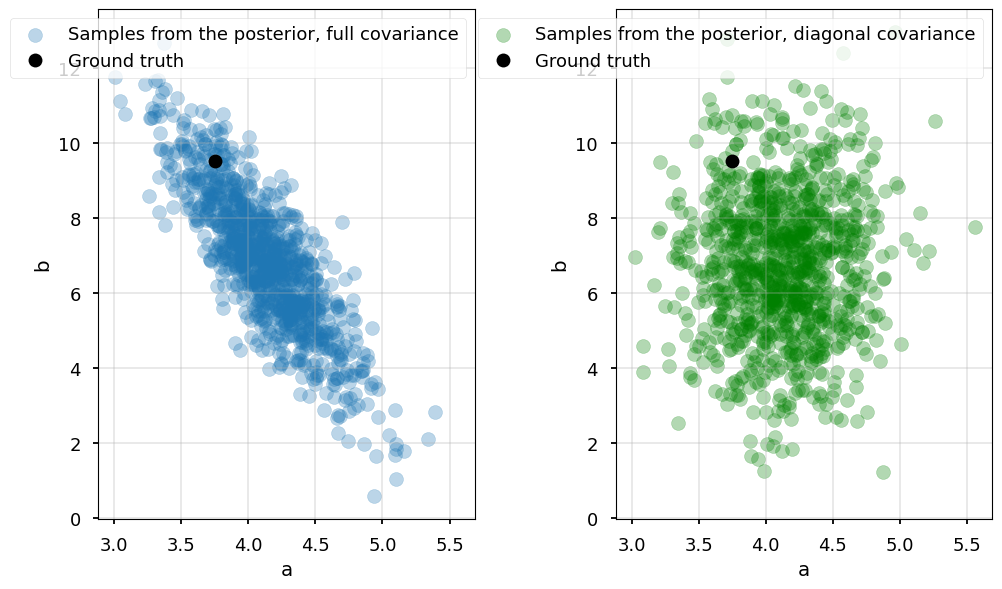

In [12]:
# lets visualize the uncertainty of the parameters by sampling from the posterior distribution given by fit mean and covariance matrix

# full posterior
curve_fit_posterior_ab_samples = np.random.multivariate_normal(mean=curve_fit_mean, cov=curve_fit_cov, size=n_posterior_samples)
curve_fit_posterior_a_samples = curve_fit_posterior_ab_samples[:, 0].reshape(1, -1)
curve_fit_posterior_b_samples = curve_fit_posterior_ab_samples[:, 1].reshape(1, -1)

# diagonal posterior
curve_fit_posterior_ab_diag_samples = np.random.multivariate_normal(mean=curve_fit_mean, cov=np.diag(np.diag(curve_fit_cov)), size=n_posterior_samples)
curve_fit_posterior_a_diag_samples = curve_fit_posterior_ab_diag_samples[:, 0].reshape(1, -1)
curve_fit_posterior_b_diag_samples = curve_fit_posterior_ab_diag_samples[:, 1].reshape(1, -1)

# plot the posterior samples
plt.figure(figsize=(10, 6))
ax1 = plt.subplot(1, 2, 1)
plt.scatter(curve_fit_posterior_a_samples, curve_fit_posterior_b_samples, label='Samples from the posterior, full covariance', s=100, alpha=0.3)
plt.plot(a_true, b_true, 'ok', label='Ground truth', markersize=10)
plt.xlabel('a')
plt.ylabel('b')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.scatter(curve_fit_posterior_a_diag_samples, curve_fit_posterior_b_diag_samples, label='Samples from the posterior, diagonal covariance', s=100, alpha=0.3, color='green')
plt.plot(a_true, b_true, 'ok', label='Ground truth', markersize=10)
plt.xlabel('a')
plt.ylabel('b')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()


Let's now visualize the posterior-predictive distribution without the noise.

<Axes: xlabel='x', ylabel='y'>

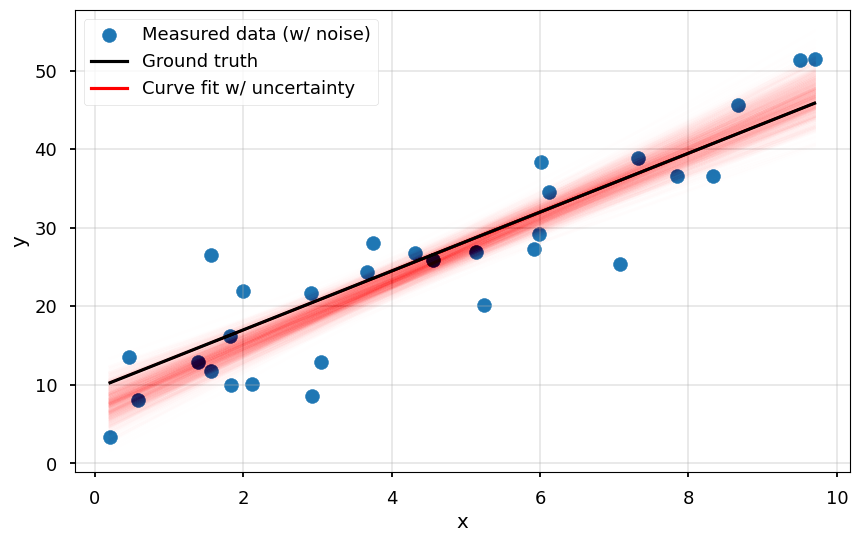

In [13]:
# predict the true y using the posterior samples of a and b
curve_fit_posterior_model = linear_model(x[:, None], curve_fit_posterior_a_samples, curve_fit_posterior_b_samples)

plt.figure(figsize=(10, 6))
plot_data(x, y_observed, y_true)
plot_posterior_model(x, curve_fit_posterior_model, posterior_label='Curve fit w/ uncertainty')

### Scikit-learn

Scikit-learn is the most popular library for machine learning in Python. It provides many fitting and machine learning methods, all with the same standard interface, so they can be used interchangeably. Fit the model using `fit` method and predict using `predict` method. Scikit-learn is the go-to library for non-parametric machine learning models and methods, but it can also do parametric fitting like linear regression. Unfortunatelly, sklearn does not provide uncertainty quantification for the parameters, just the point estimate.

In [14]:
from sklearn.linear_model import LinearRegression

In [15]:
lr = LinearRegression()
lr.fit(x.reshape(-1, 1), y_observed)

# store the results in a dataframe (will be printed at the end of the notebook)
fit_results_df.loc['sklearn'] = {
    'a': lr.coef_[0], 
    'b': lr.intercept_,
    'a_err': np.nan,
    'b_err': np.nan,
    'ab_cov': np.nan,
}
fit_results_df


,a,b,a_err,b_err,ab_cov
method,,,,,
true parameters,3.750000,9.510000,NaN,NaN,NaN
curve_fit,4.121503,6.779359,0.366494,1.902464,-0.589114
linregress,4.121503,6.779359,0.366494,1.902464,NaN
sklearn,4.121503,6.779359,NaN,NaN,NaN


The same result as with scipy. Just the point estimate. No confidence intervals.

### Naive bootstrap



For the first time, we will implement the bootstrap method ourselves, below we will use `arch` library to achieve the same result more efficiently and elegantly.

Bootstrap is a resampling technique that is used to estimate the uncertainty of a statistic or parameter fit. It is a non-parametric method that does not assume any particular distribution of the data.

Principle of the bootstrap lies in resampling the empirical distribution of the data with replacement.

In other notebooks we will see that when the data are correlated, one has to use a more sophisticated variants of the bootstrap, but here we will stick to the simple case and assume that the data are independent.

In [16]:
def bootstrap(data: np.ndarray, n_samples: int) -> np.ndarray:
    """
    Bootstrap the data.

    Parameters
    ----------
    data : np.ndarray
        N-dimensional data to bootstrap along the first dimension.
    n_samples : int
        The number of samples to draw from the data.

    Returns
    -------
    np.ndarray
        The bootstraped data.
    """

    # draw indices of the data with replacement
    inds = np.random.choice(np.arange(data.shape[0]), size=(n_samples, data.shape[0]), replace=True)
    return data[inds, ...]

# draw 1000 bootstraps of 100 samples from the data
xy = np.stack([x, y_observed], axis=1)
bootstrap_samples = bootstrap(data=xy, n_samples=n_posterior_samples)

x_bootstrapped = bootstrap_samples[:, :, 0]
y_bootstrapped = bootstrap_samples[:, :, 1]

print(f'Bootstrap samples shape: {bootstrap_samples.shape} (bootstrap_sample, n_samples, n_dim)')


Bootstrap samples shape: (1000, 30, 2) (bootstrap_sample, n_samples, n_dim)


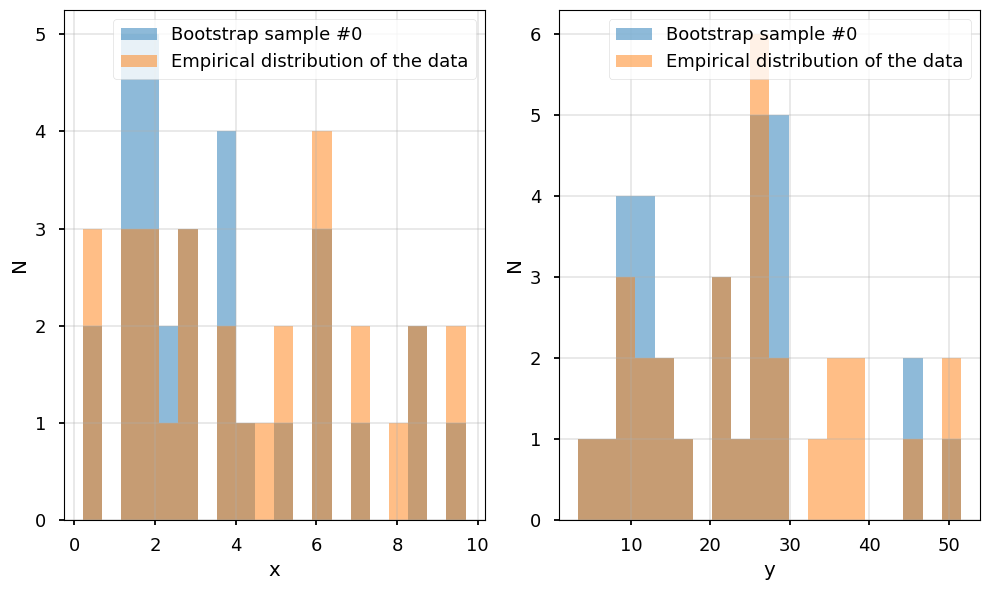

In [17]:
# compare empirical distribution of the bootstrap samples to the true empirical distribution

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
_, bins, _ = plt.hist(x_bootstrapped[0, :], bins=20, label='Bootstrap sample #0', alpha=0.5)
plt.hist(x, bins=bins, label='Empirical distribution of the data', alpha=0.5)
plt.xlabel('x')
plt.ylabel('N')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
_, bins, _ = plt.hist(y_bootstrapped[0, :], bins=20, label='Bootstrap sample #0', alpha=0.5)
plt.hist(y_observed, bins=bins, label='Empirical distribution of the data', alpha=0.5)
plt.xlabel('y')
plt.ylabel('N')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [18]:
# now let's fit one model to each bootstrap sample (naive approach)

bootstrap_fit_means = []
bootstrap_fit_covs = []
for x_sample, y_sample in tqdm(zip(x_bootstrapped, y_bootstrapped)):
    fit_mean, fit_cov = curve_fit(
        f=linear_model,
        xdata=x_sample,
        ydata=y_sample,
    )
    bootstrap_fit_means.append(fit_mean)
    bootstrap_fit_covs.append(fit_cov)

bootstrap_fit_means = np.array(bootstrap_fit_means)
bootstrap_fit_covs = np.array(bootstrap_fit_covs)

fit_results_df.loc['bootstrap'] = {
    'a': np.mean(bootstrap_fit_means[:, 0]),
    'b': np.mean(bootstrap_fit_means[:, 1]),
    'a_err': np.std(bootstrap_fit_means[:, 0]),
    'b_err': np.std(bootstrap_fit_means[:, 1]),
    'ab_cov': np.cov(bootstrap_fit_means[:, 0], bootstrap_fit_means[:, 1])[0, 1],
}

print('Bootstrap fit means shape:', bootstrap_fit_means.shape)
print('Bootstrap fit covariances shape:', bootstrap_fit_covs.shape)
fit_results_df


1000it [00:00, 4189.33it/s]

Bootstrap fit means shape: (1000, 2)
Bootstrap fit covariances shape: (1000, 2, 2)


,a,b,a_err,b_err,ab_cov
method,,,,,
true parameters,3.750000,9.510000,NaN,NaN,NaN
curve_fit,4.121503,6.779359,0.366494,1.902464,-0.589114
linregress,4.121503,6.779359,0.366494,1.902464,NaN
sklearn,4.121503,6.779359,NaN,NaN,NaN
bootstrap,4.106321,6.800943,0.376097,1.941585,-0.629717


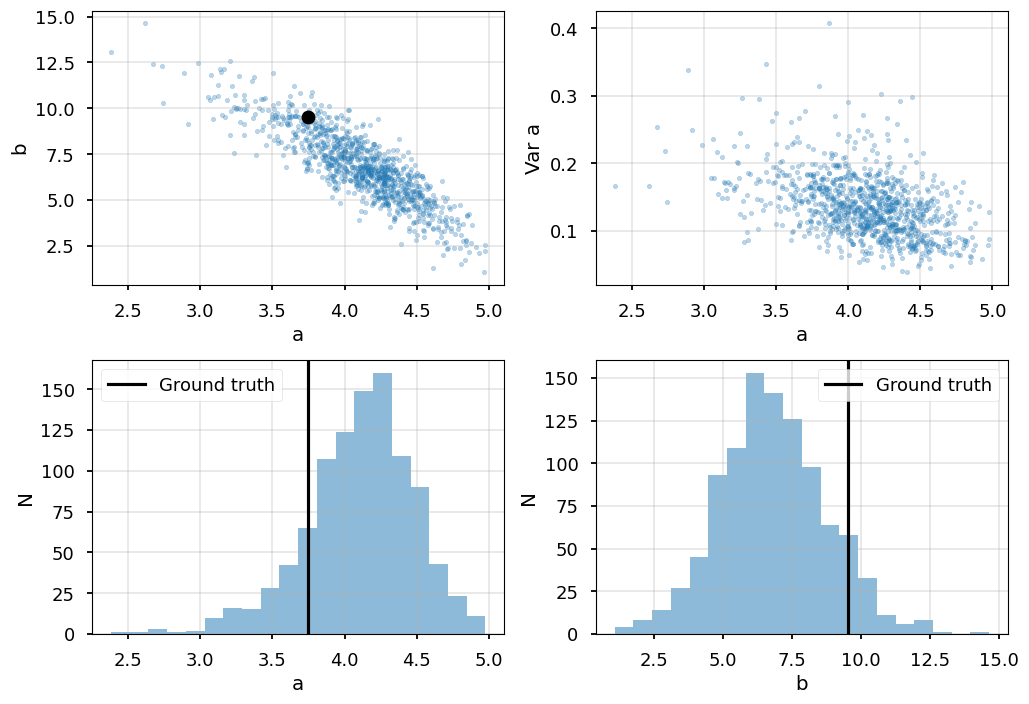

In [19]:
# Note that the bootstraped parameters are not exactly normal-distributed (even though in this case they are close to it).
plot_parameter_uncertainty(bootstrap_fit_means, bootstrap_fit_covs)

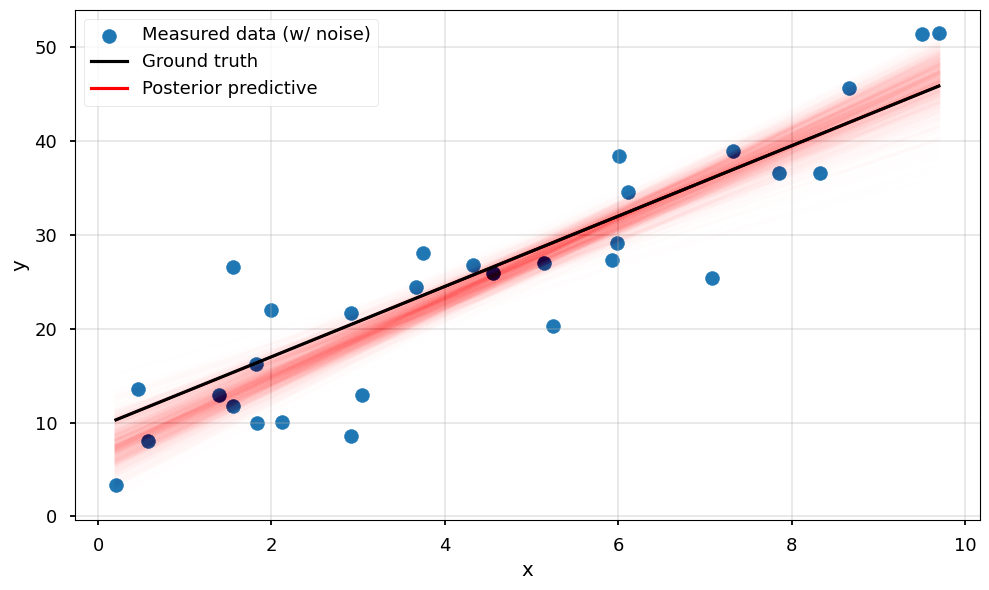

In [20]:
bootstrap_posterior_model = linear_model(x[None, :], bootstrap_fit_means[:, :1], bootstrap_fit_means[:, -1:]).T

plt.figure(figsize=(10, 6))
plot_data(x, y_observed, y_true)
plot_posterior_model(x, bootstrap_posterior_model)
plt.tight_layout()
plt.show()


### Bootstrap with arch

In [21]:
from arch.bootstrap import IIDBootstrap  # assuming i.i.d. (non-correlated) data; if there's correlation, use BlockBootstrap or CircularBlockBootstrap or StationaryBootstrap

def fit_linear_model(x, y):
    fit_mean, fit_cov = curve_fit(
        f=linear_model,
        xdata=x,
        ydata=y,
    )
    return np.hstack([fit_mean, fit_cov.ravel()])  # (a, b, cov11, cov12, cov21, cov22)

iid_bootstrap = IIDBootstrap(x=x, y=y_observed)
arch_param_bootstrap = iid_bootstrap.apply(fit_linear_model, reps=n_posterior_samples)  # reps is the number of bootstrap samples

fit_results_df.loc['bootstrap_arch'] = {
    'a': np.mean(arch_param_bootstrap[:, 0]),
    'b': np.mean(arch_param_bootstrap[:, 1]),
    'a_err': np.std(arch_param_bootstrap[:, 0]),
    'b_err': np.std(arch_param_bootstrap[:, 1]),
    'ab_cov': np.cov(arch_param_bootstrap[:, 0], arch_param_bootstrap[:, 1])[0, 1],
}

print(f'Bootstrap samples shape: {arch_param_bootstrap.shape} (n_bootstraps, n_params)')
fit_results_df

Bootstrap samples shape: (1000, 6) (n_bootstraps, n_params)


,a,b,a_err,b_err,ab_cov
method,,,,,
true parameters,3.750000,9.510000,NaN,NaN,NaN
curve_fit,4.121503,6.779359,0.366494,1.902464,-0.589114
linregress,4.121503,6.779359,0.366494,1.902464,NaN
sklearn,4.121503,6.779359,NaN,NaN,NaN
bootstrap,4.106321,6.800943,0.376097,1.941585,-0.629717
bootstrap_arch,4.090525,6.842449,0.351101,1.889940,-0.566198


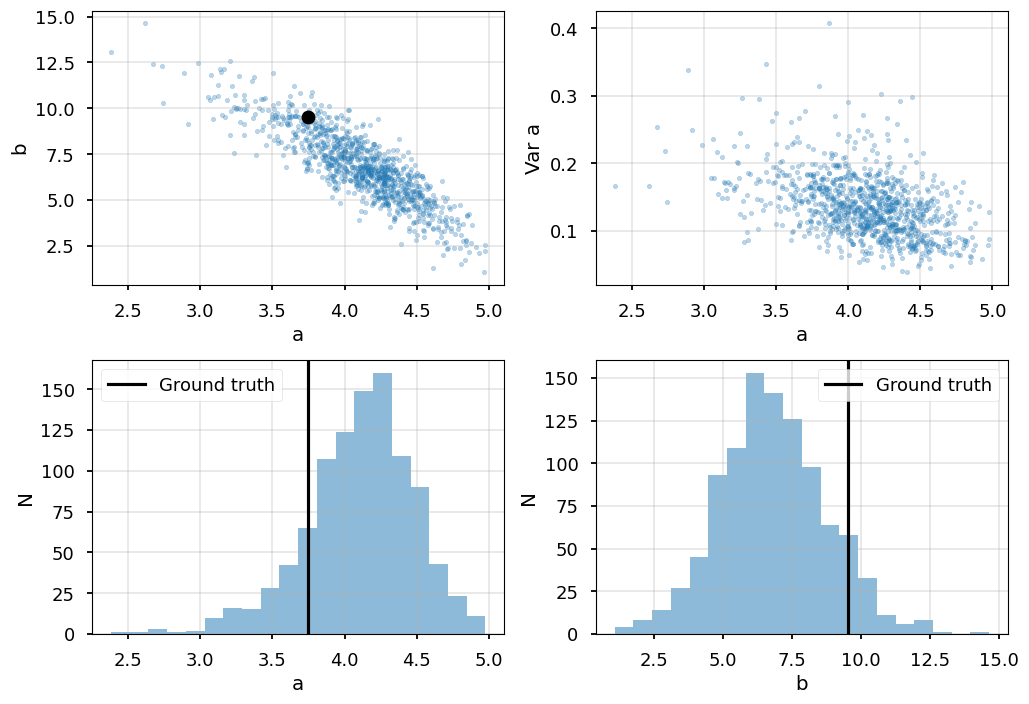

In [22]:
# Note that the bootstraped parameters are not exactly normal-distributed (even though in this case they are close to it).
plot_parameter_uncertainty(bootstrap_fit_means, bootstrap_fit_covs)

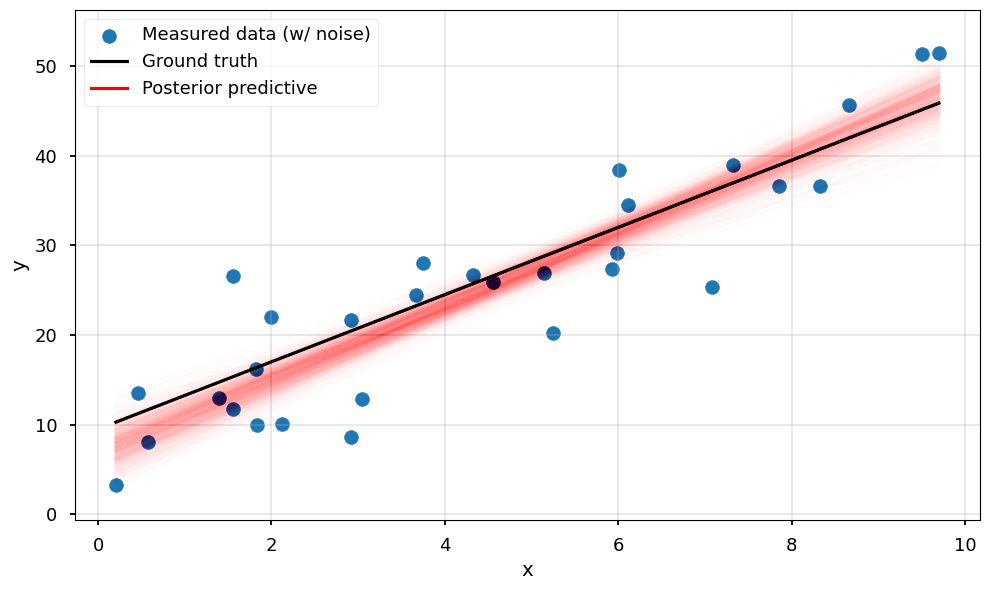

In [23]:
arch_bootstrap_posterior_model = linear_model(x[None, :], arch_param_bootstrap[:, :1], arch_param_bootstrap[:, 1:2]).T

plt.figure(figsize=(10, 6))
plot_data(x, y_observed, y_true)
plot_posterior_model(x, arch_bootstrap_posterior_model)
plt.tight_layout()
plt.show()

### Bayesian inference with PyMC

In [24]:
import pymc as pm

with pm.Model() as model:
    # priors for the parameters and the noise
    a = pm.Normal('a', mu=0, sigma=3)  # prior for a
    b = pm.Normal('b', mu=0, sigma=10)  # prior for b
    sigma = pm.HalfNormal('sigma', sigma=1)  # prior for the noise

    # the deterministic model
    model_prediction = pm.Deterministic('model_prediction', a * x + b)

    # the likelihood
    y = pm.Normal('y', mu=model_prediction, sigma=sigma, observed=y_observed)

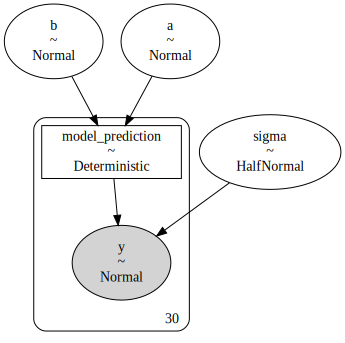

In [25]:
# let's visualize the model (needs graphviz library installed)
pm.model_to_graphviz(model)

Sampling: [a, b, sigma, y]


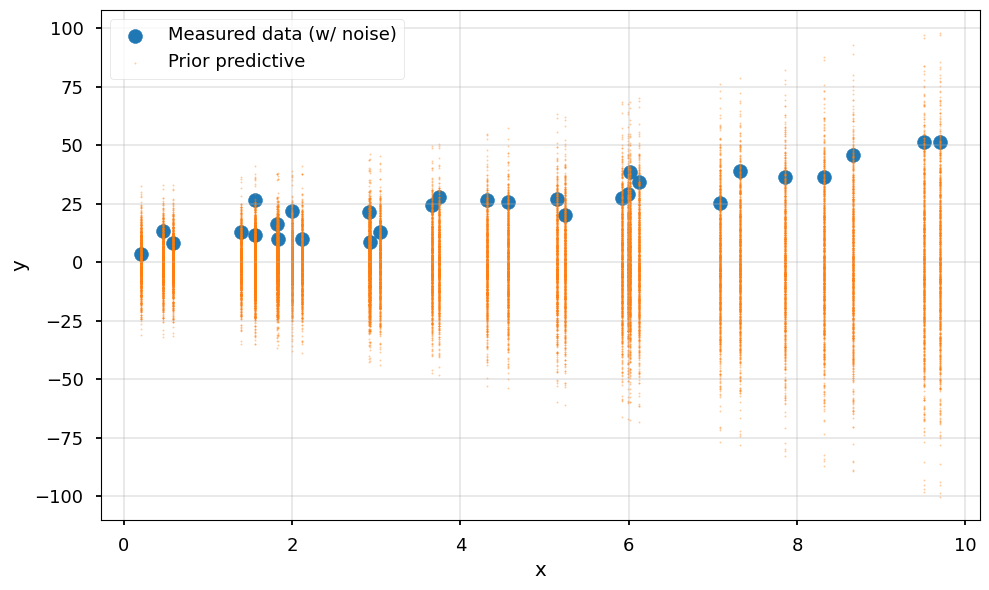

In [26]:
# plot prior predictive and asses whether the data are consistent with the prior and the prior is not too wide
num_prior_samples = 1000
with model:
    bayesian_prior_predictive = pm.sample_prior_predictive(samples=num_prior_samples)

plt.figure(figsize=(10, 6))
plot_data(x, y_observed)
plt.scatter(np.tile(x, (num_prior_samples, 1)), bayesian_prior_predictive.prior_predictive['y'][0], s=1, alpha=0.3, label='Prior predictive')
plt.legend()

plt.tight_layout()
plt.show()


In [27]:
# sample from the posterior
# IMPORTANT: always for warnings about divergences and R_hat statistics
with model:
    bayesian_trace = pm.sample(
        tune=1000,  # number of steps for tuning the sampler (burn-in, not used for inference but helps with convergence)
        draws=1000,  # number of samples to draw from the posterior in each chain
        chains=4,  # number of chains to run in parallel (more chains -> more samples)
        progressbar=True,  # show a progress bar
        # target_accept=0.95  # target acceptance rate - increase if getting divergences
        # max_treedepth=12  # increase if getting divergences
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [a, b, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


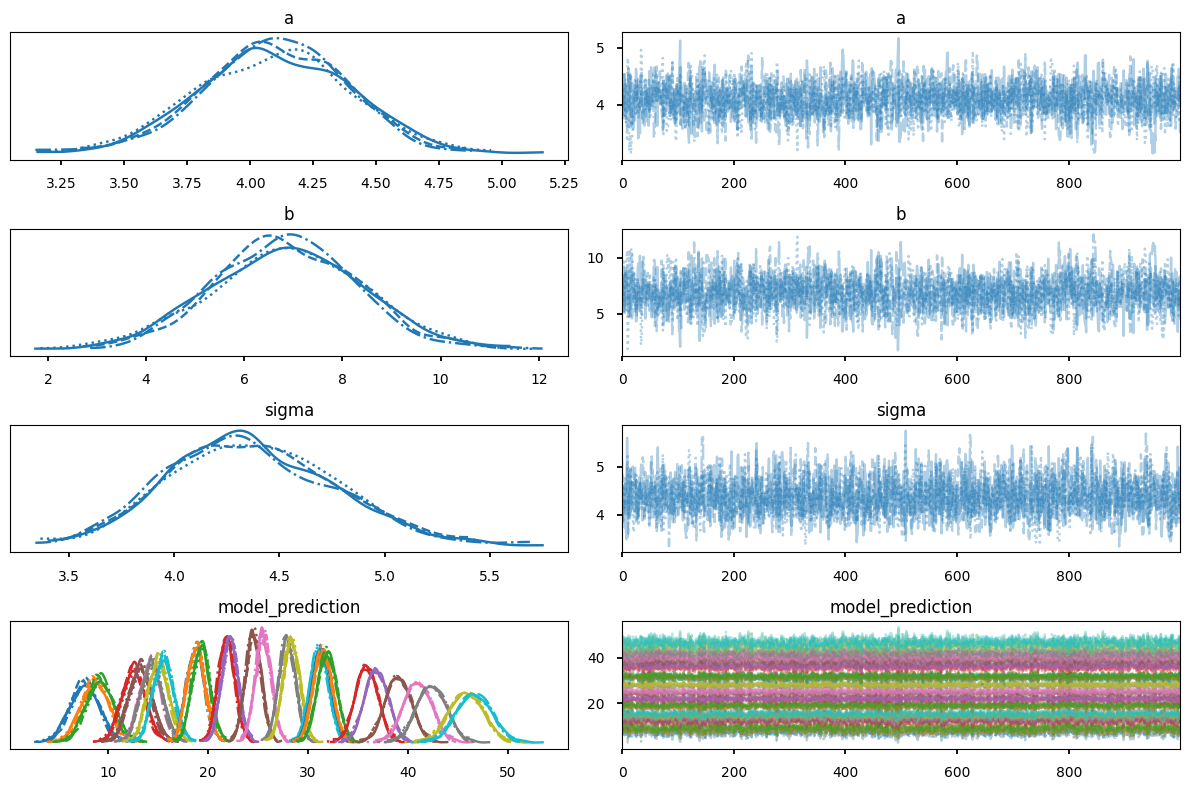

In [28]:
# plot the trace
# left part - distribution of posterior samples for each chain (all chains should be close to each other)
# right part - trace of the parameters in each chain - should look random
pm.plot_trace(bayesian_trace)
plt.tight_layout()


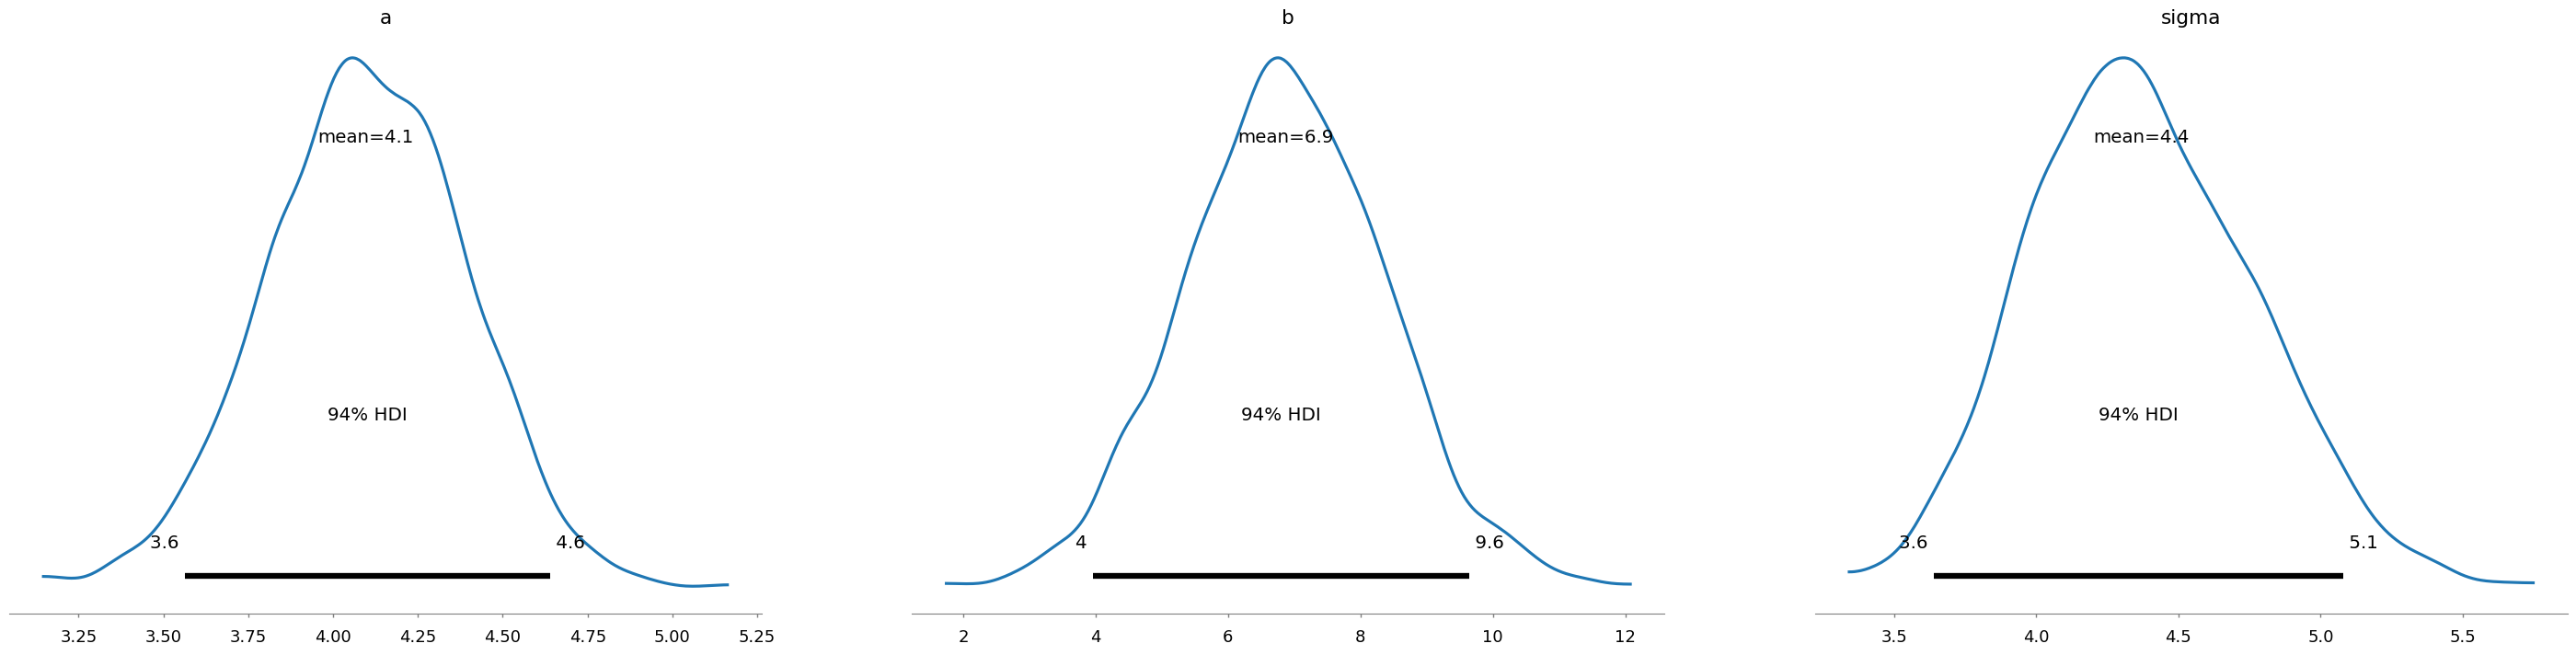

In [29]:
# we can visualize the posterior distribution of the parameters without the trace using arviz
import arviz as az
az.plot_posterior(bayesian_trace, var_names=["a", "b", "sigma"]);


In [30]:
fit_results_df.loc['bayesian'] = {
    'a': np.mean(bayesian_trace.posterior['a'].values),
    'b': np.mean(bayesian_trace.posterior['b'].values),
    'a_err': np.std(bayesian_trace.posterior['a'].values),
    'b_err': np.std(bayesian_trace.posterior['b'].values),
    'ab_cov': np.cov(bayesian_trace.posterior['a'], bayesian_trace.posterior['b'])[0, 1],
}
fit_results_df

,a,b,a_err,b_err,ab_cov
method,,,,,
true parameters,3.750000,9.510000,NaN,NaN,NaN
curve_fit,4.121503,6.779359,0.366494,1.902464,-0.589114
linregress,4.121503,6.779359,0.366494,1.902464,NaN
sklearn,4.121503,6.779359,NaN,NaN,NaN
bootstrap,4.106321,6.800943,0.376097,1.941585,-0.629717
bootstrap_arch,4.090525,6.842449,0.351101,1.889940,-0.566198
bayesian,4.096292,6.862640,0.290678,1.512957,0.001909


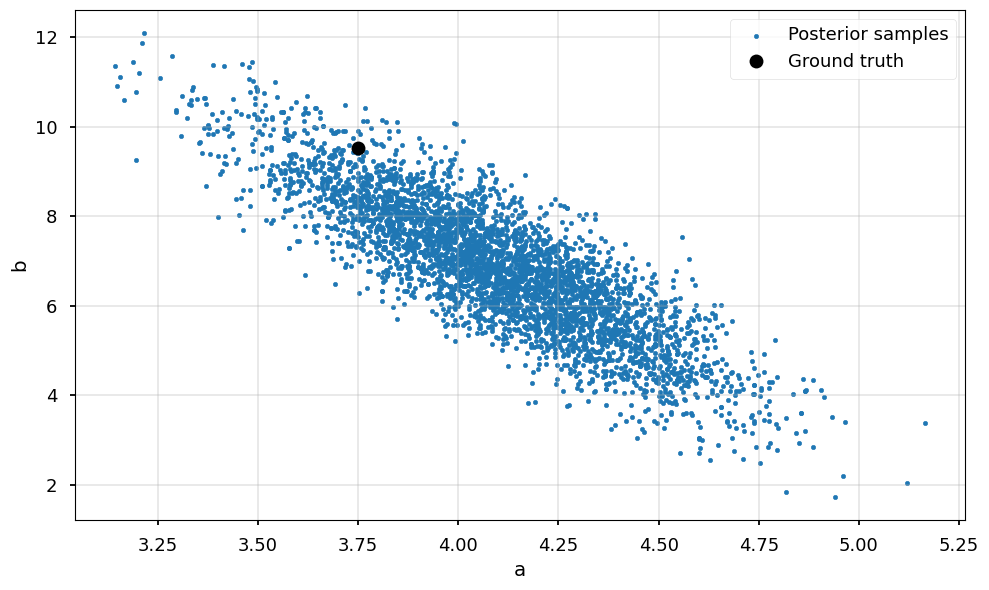

In [31]:
# we can access the posterior samples for each parameter directly and plot them
plt.figure(figsize=(10, 6))
plt.scatter(bayesian_trace.posterior['a'], bayesian_trace.posterior['b'], s=10, label='Posterior samples')
plt.plot(a_true, b_true, 'ok', label='Ground truth', markersize=10)
plt.xlabel('a')
plt.ylabel('b')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


Sampling: [y]


Output()

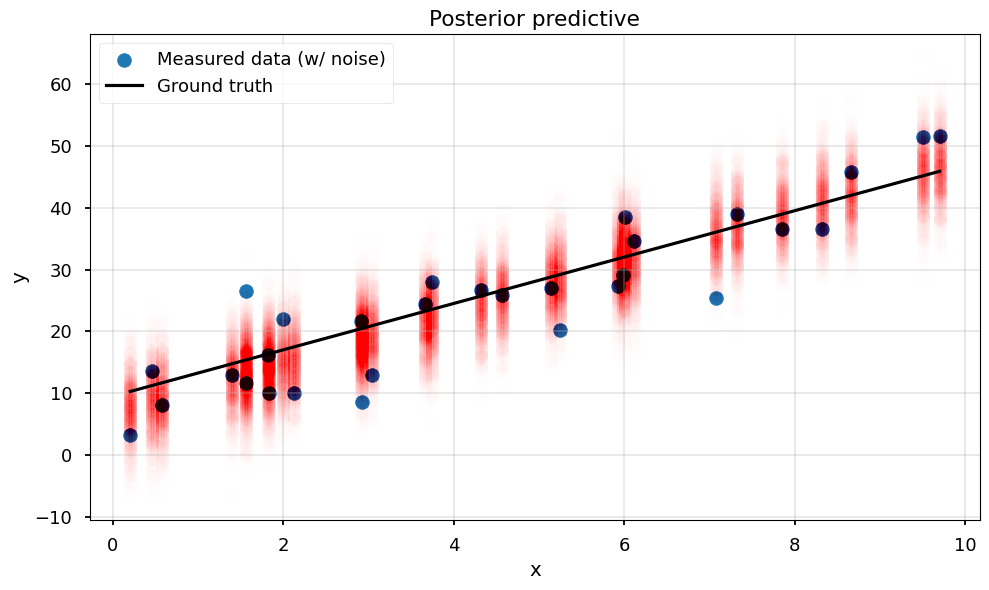

In [32]:
# plot posterior predictive - sample from the model with the posterior parameters
with model:
    bayesian_posterior_predictive = pm.sample_posterior_predictive(bayesian_trace, var_names=['y', 'model_prediction'])

plt.figure(figsize=(10, 6))
plot_data(x, y_observed, y_true)
plt.scatter(np.tile(x, (1000, 1)), bayesian_posterior_predictive.posterior_predictive['y'][0], label='Posterior predictive', color='red', alpha=0.005)
plt.title('Posterior predictive')

plt.tight_layout()
plt.show()

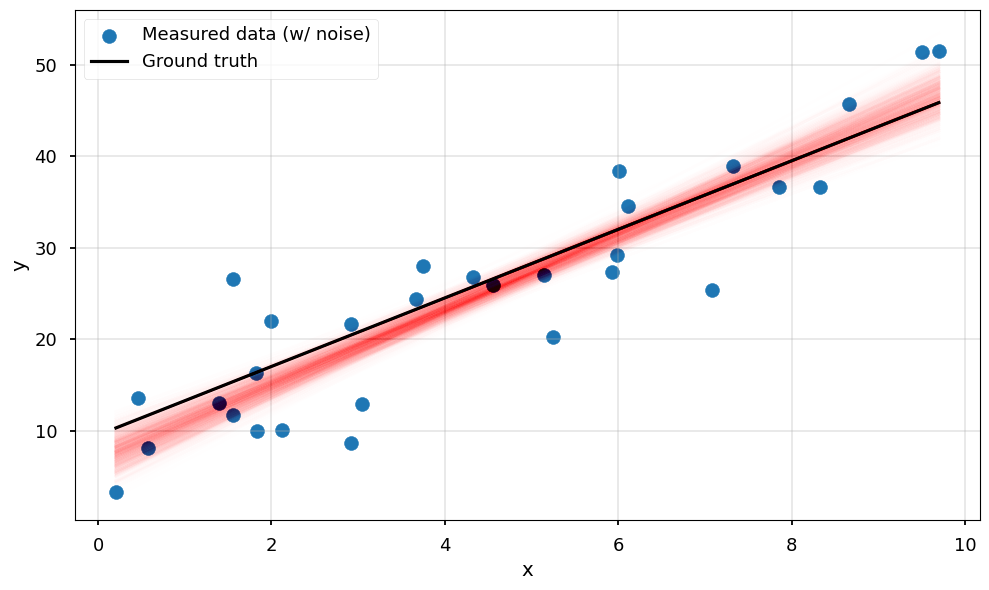

In [33]:
# the previous plot sampled y_observed, this one samples y_true and plots the uncertainty of the deterministic part of the model
plt.figure(figsize=(10, 6))
plot_data(x, y_observed, y_true)
plt.plot(x, bayesian_posterior_predictive.posterior_predictive['model_prediction'][0].T, color='red', alpha=0.005)

plt.tight_layout()
plt.show()

## Final comparison

In this simple case, all fitting methods gave similar results, but none of them came realy close to the ground truth. This is caused by the low number of samples and relatively high noise.

TODO: Try to increase the number of samples at the beginning of the notebook and see if the results improve.

In [34]:
fit_results_df

,a,b,a_err,b_err,ab_cov
method,,,,,
true parameters,3.750000,9.510000,NaN,NaN,NaN
curve_fit,4.121503,6.779359,0.366494,1.902464,-0.589114
linregress,4.121503,6.779359,0.366494,1.902464,NaN
sklearn,4.121503,6.779359,NaN,NaN,NaN
bootstrap,4.106321,6.800943,0.376097,1.941585,-0.629717
bootstrap_arch,4.090525,6.842449,0.351101,1.889940,-0.566198
bayesian,4.096292,6.862640,0.290678,1.512957,0.001909
